In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# pipeline construction
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# data processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

# models trainng
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

# models validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# remove annoying warnings
import warnings
warnings.filterwarnings('ignore')

## Download data

In [2]:
df_raw = sns.load_dataset('titanic')
df_raw.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
# shufle data is a good practice
df_raw = df_raw.sample(frac=1).reset_index(drop=True)
df_raw.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,1,2,female,50.0,0,0,10.500,S,Second,woman,False,NaN,Southampton,yes,True
1,0,1,male,36.0,0,0,40.125,C,First,man,True,A,Cherbourg,no,True
2,0,3,male,NaN,0,0,8.050,S,Third,man,True,NaN,Southampton,no,True
3,0,3,male,2.0,3,1,21.075,S,Third,child,False,NaN,Southampton,no,False
4,0,2,male,25.0,0,0,13.000,S,Second,man,True,NaN,Southampton,no,True


In [4]:
df_raw.shape

(891, 15)

In [5]:
# split data into training and test set 
X_train, X_test, y_train, y_test = train_test_split(df_raw.drop('survived', axis=1), 
                                                    df_raw['survived'], 
                                                    test_size=0.2,
                                                    stratify=df_raw['survived'],
                                                    random_state=42)

## Basic Exploratory Data Analysis

In [6]:
# columns type
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
survived       891 non-null int64
pclass         891 non-null int64
sex            891 non-null object
age            714 non-null float64
sibsp          891 non-null int64
parch          891 non-null int64
fare           891 non-null float64
embarked       889 non-null object
class          891 non-null category
who            891 non-null object
adult_male     891 non-null bool
deck           203 non-null category
embark_town    889 non-null object
alive          891 non-null object
alone          891 non-null bool
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB


In [7]:
# basic statistics
df_raw.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Unique values per column

In [8]:
for column in df_raw:
    print(f'{column} - {len(df_raw[column].unique())}')
    print(df_raw[column].unique())
    print()

survived - 2
[1 0]

pclass - 3
[2 1 3]

sex - 2
['female' 'male']

age - 89
[50.   36.     nan  2.   25.   40.   19.   48.   26.   54.   33.   22.
 16.   44.   32.   71.   28.    0.75 27.   29.   30.   24.   65.    8.
 14.   37.   39.   52.   31.   61.   17.   24.5  23.   21.   58.   38.
 57.    0.42 18.   46.    9.   20.   45.    1.   62.   47.   35.    3.
 49.   41.   11.   15.   32.5  80.   42.   40.5  43.    0.83 34.   13.
  0.92  4.   36.5  70.   53.   74.    6.    5.   34.5  30.5   7.   12.
 64.   28.5  14.5  60.   10.   56.   59.   51.   55.5  63.    0.67 45.5
 23.5  55.   66.   70.5  20.5 ]

sibsp - 7
[0 3 2 1 5 8 4]

parch - 7
[0 1 3 2 5 4 6]

fare - 248
[ 10.5     40.125    8.05    21.075   13.      26.55     7.8958   7.8542
   6.75     7.75     8.6625  51.8625   7.8292   7.775   66.6     18.
   7.2292  27.7208   8.3625  34.6542   7.225   19.2583  26.     134.5
  30.      39.4     31.      18.75    28.7125  52.      61.9792  16.7
  36.75    46.9      9.5875   6.95    78.2667 

### Missing values

In [9]:
a = df_raw.isna().mean()*100
a[a>0]

age            19.865320
embarked        0.224467
deck           77.216611
embark_town     0.224467
dtype: float64

In [10]:
a = df_raw.isna().sum()
a[a>0]

age            177
embarked         2
deck           688
embark_town      2
dtype: int64

### Distributions

In [11]:
numeric_columns = df_raw.select_dtypes(include=np.number).columns
numeric_columns

Index(['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare'], dtype='object')

In [12]:
non_numeric_columns = df_raw.select_dtypes(exclude=np.number).columns
non_numeric_columns

Index(['sex', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')

### Numeric columns

Column: survived
Unique values: 2


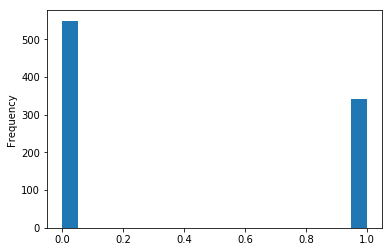

Column: pclass
Unique values: 3


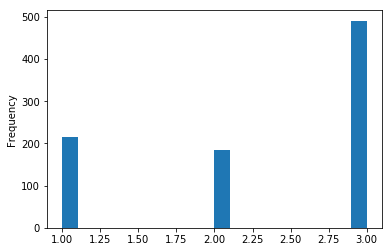

Column: age
Unique values: 89


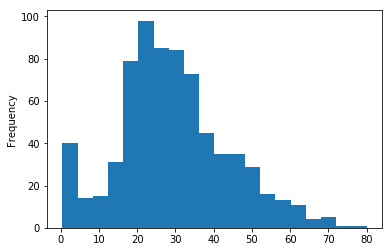

Column: sibsp
Unique values: 7


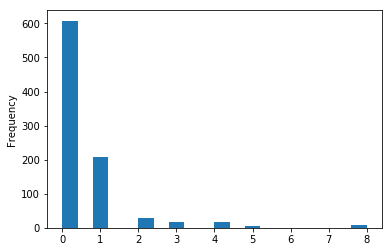

Column: parch
Unique values: 7


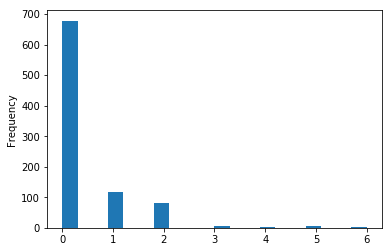

Column: fare
Unique values: 248


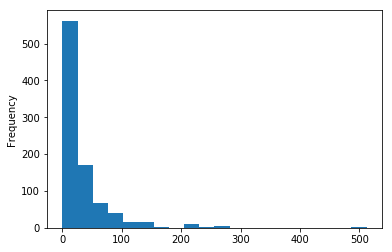

In [13]:
for column in numeric_columns:
    print(f'Column: {column}')
    print(f'Unique values: {len(df_raw[column].unique())}')
    df_raw[column].plot.hist(bins=20)
    plt.show()

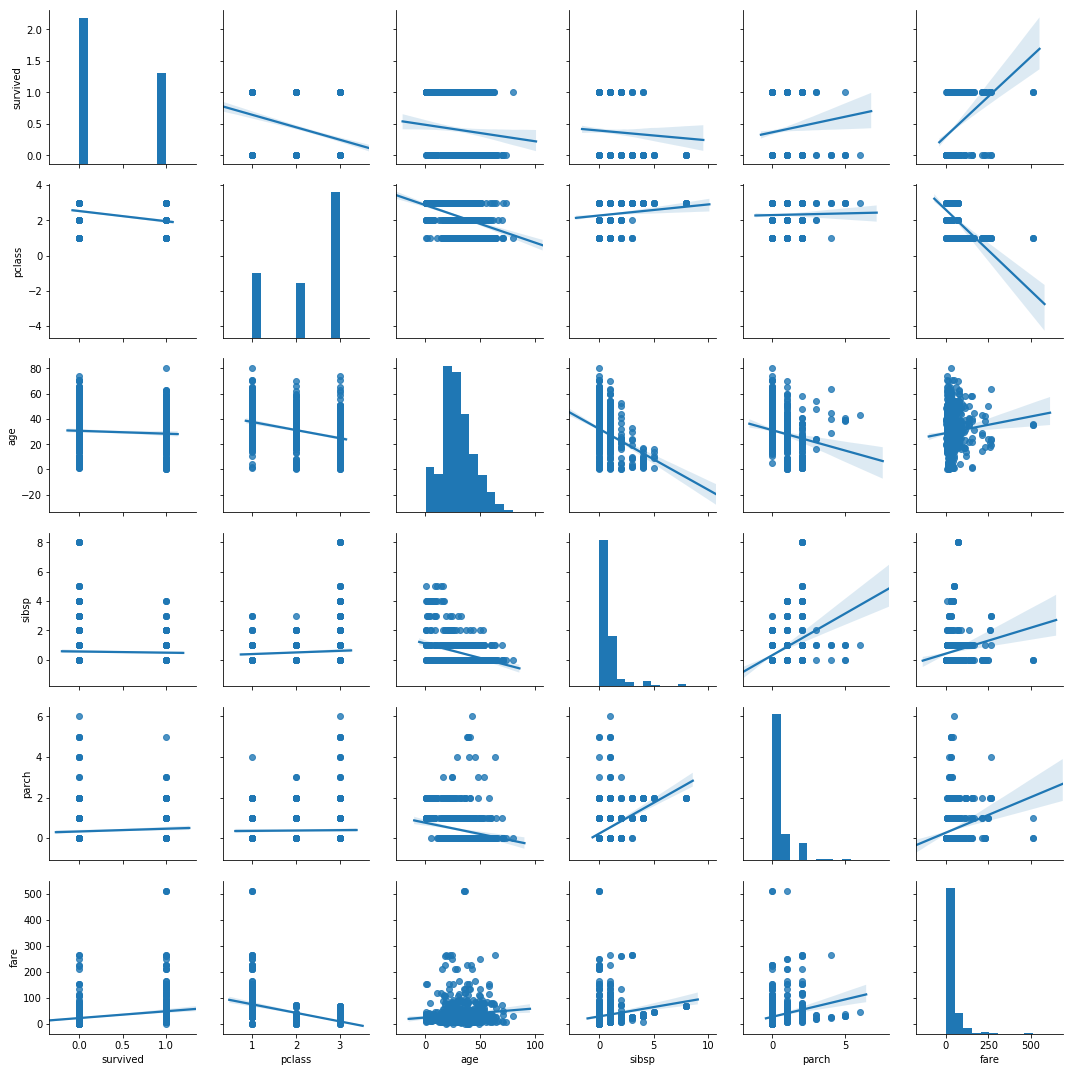

In [14]:
# mutual dependencies
df_numeric = df_raw.select_dtypes(include=np.number)
sns.pairplot(df_numeric, kind='reg')
plt.show()

### Categorical columns

Columns: sex
Unique values: 2


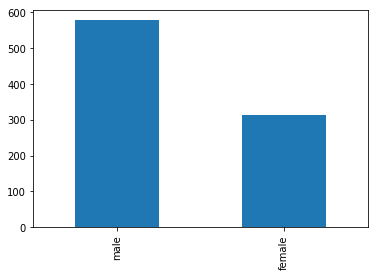

Columns: embarked
Unique values: 4


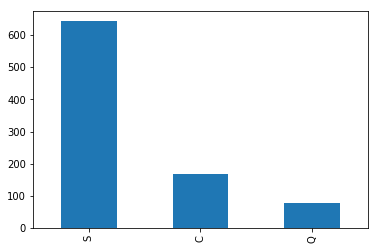

Columns: class
Unique values: 3


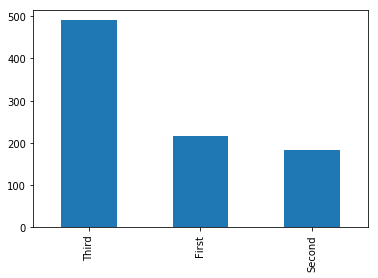

Columns: who
Unique values: 3


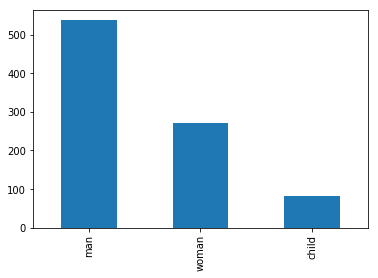

Columns: adult_male
Unique values: 2


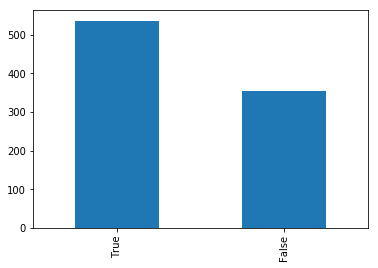

Columns: deck
Unique values: 8


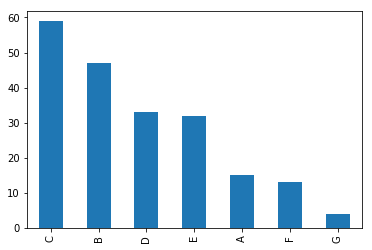

Columns: embark_town
Unique values: 4


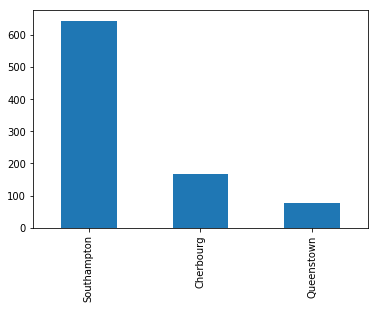

Columns: alive
Unique values: 2


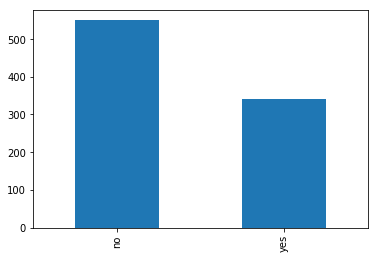

Columns: alone
Unique values: 2


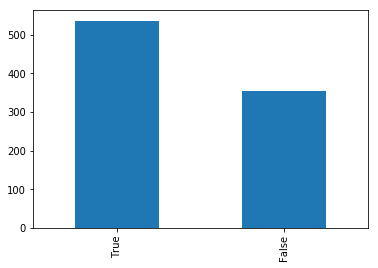

In [15]:
for column in non_numeric_columns:
    print(f'Columns: {column}')
    print(f'Unique values: {len(df_raw[column].unique())}')
    df_raw[column].value_counts().plot.bar()
    plt.show()

In [16]:
df_raw.head(2)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,1,2,female,50.0,0,0,10.500,S,Second,woman,False,NaN,Southampton,yes,True
1,0,1,male,36.0,0,0,40.125,C,First,man,True,A,Cherbourg,no,True


### Conclusions:
* there are duplicated columns - survived and alive, pclass and class, embark and embark_town: to be removed
* there are columns with too many missing values: 'deck'. 'Age' can be kept and imputed
* numeric columns are skewed. For linear algorithms it can be a problem. Log or Yeo-Jonson transformation may help
* binary column 'alone' should be truned to 0-1.
* categorical columns should be encoded using one-hot encoding.<br>
__Consider:__
* 'who' can be turned to 'adult' and 'child' => 'adult_male' can be then removed as a redundant one
* not to remove 'deck' with new category 'Missing'
* create new features (multiplication of class and sex; multiplication of sex and age)


# Simplest Pipeline

In [17]:
# data
X_1 = pd.DataFrame(df_raw['pclass'])
y_1 = df_raw['survived']

# steps of the pipeline
steps = [
    ('scaler', MinMaxScaler()),
    # if the pipeline has the model, it MUST be the last step
    ('model', LogisticRegression()) 
    
    # however, the pipeline can be only for features transforming, not for prediction
]

# pipeline definition
pipeline_1 = Pipeline(steps=steps)

# pipeline training / fitting
pipeline_1.fit(X_1, y_1)

# prediction using the pipeline
preds = pipeline_1.predict(X_1)
preds[:5]

array([0, 1, 0, 0, 0])

In [18]:
# pipeline evaluation
pipeline_1.score(X_1, y_1)

0.6790123456790124

In [25]:
pipeline_1.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
  ('model',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='warn',
             n_jobs=None, penalty='l2', random_state=None, solver='warn',
             tol=0.0001, verbose=0, warm_start=False))],
 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__max_iter': 100,
 'model__multi_class': 'warn',
 'model__n_jobs': None,
 'model__penalt

In [20]:
pipeline_1.named_steps

{'scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False)}

In [23]:
pipeline_1.named_steps['scaler']

MinMaxScaler(copy=True, feature_range=(0, 1))

In [24]:
pipeline_1.steps

[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
 ('model',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=None, solver='warn',
            tol=0.0001, verbose=0, warm_start=False))]

## Task 1 - data transformation
* As a features, take class and fare. 
* Add Standard Scaler
* Add PCA step to the pipeline with the only component
* Show transformed features 

## Task 2 - prediction
* As a features, take class and fare. 
* Add Standard Scaler
* Add PCA step to the pipeline with the only component
* Add the estimator at the end of the pipeline
* Evaluate the model

In [26]:
# data transformation

from sklearn.decomposition import PCA
X_2 = df_raw[['pclass', 'fare']]
y_2 = df_raw['survived']

steps = [
    ('scaler', StandardScaler()),
    ('pca', PCA(1)) 
]

pipeline_2 = Pipeline(steps=steps)

pipeline_2.fit(X_2, y_2)
pipeline_2.transform(X_2)[:5]

array([[-0.04783054],
       [ 1.2201761 ],
       [-0.92893655],
       [-0.74349475],
       [-0.0122371 ]])

In [27]:
# prediction

steps = [
    ('scaler', StandardScaler()),
    ('pca', PCA(1)), 
    ('model', LogisticRegression())
]

pipeline_2 = Pipeline(steps=steps)
pipeline_2.fit(X_2, y_2)

pipeline_2.score(X_2, y_2)

0.6801346801346801

# Custom Transformers
* allows to implement any logic on features
* can be included as a step into the pipeline

## Transformer for removing columns from the dataset
* no fit method implementation

In [28]:
# transformer must be defined as a class
# implementing two methods: fit and transform
class RemoveColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, columns_to_remove: list):
        self.columns_to_remove = columns_to_remove
    
    # even if nothing to fit, this method must return self
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        return X.drop(self.columns_to_remove, axis=1)

In [29]:
# define test dataset
X_2 = df_raw[['pclass', 'fare']]

# initialize the transformer
rc = RemoveColumnsTransformer(columns_to_remove=['fare'])

# fit and transform transformer
rc.fit(X_2)
transformed_df = rc.transform(X_2)
transformed_df.head()

,pclass
0,2
1,1
2,3
3,3
4,2


## Task 3

* create custom transformer SelectColumnsTransformer which can select specified columns from the dataset
* return pclass and fare

In [30]:
class SelectColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, columns_to_select: list):
        self.columns_to_select = columns_to_select
    
    # even if nothing to fit, this method must return self
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        return X[self.columns_to_select]

In [31]:
# define test dataset
X_2 = df_raw[['pclass', 'fare']]

# initialize the transformer
rc = SelectColumnsTransformer(columns_to_select=['fare'])

# fit and transform transformer
rc.fit(X_2)
transformed_df = rc.transform(X_2)
transformed_df.head()

,fare
0,10.500
1,40.125
2,8.050
3,21.075
4,13.000


## Task 3.1 
* create transformer __SelectColumnsByTypeTransformer__ which can select columns by type - 'numeric' or 'object'

In [32]:
class SelectColumnsByTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, type_to_select):
        self.type_to_select = type_to_select
    
    # even if nothing to fit, this method must return self
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        if self.type_to_select == 'numeric':
            return X.select_dtypes(include=np.number)
        else:
            return X.select_dtypes(exclude=np.number)

In [34]:
selector = SelectColumnsByTypeTransformer(type_to_select='numeric')
selector.fit_transform(df_raw).head()

,survived,pclass,age,sibsp,parch,fare
0,1,2,50.0,0,0,10.500
1,0,1,36.0,0,0,40.125
2,0,3,NaN,0,0,8.050
3,0,3,2.0,3,1,21.075
4,0,2,25.0,0,0,13.000


In [35]:
selector = SelectColumnsByTypeTransformer(type_to_select='object')
selector.transform(df_raw).head()

,sex,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,female,S,Second,woman,False,NaN,Southampton,yes,True
1,male,C,First,man,True,A,Cherbourg,no,True
2,male,S,Third,man,True,NaN,Southampton,no,True
3,male,S,Third,child,False,NaN,Southampton,no,False
4,male,S,Second,man,True,NaN,Southampton,no,True


## Transformer for missing data imputation
* fit method implementation

In [36]:
class ImputeNumColsTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, method='mean'):
        self.method=method
        # for keeping values to impute any specified column
        self.impute_values = {}
        
    def fit( self, X, y = None ):
        if self.method == 'mean':
            for col in X:
                mean = X[col].mean()
                self.impute_values[col] = mean   
        return self 
    
    def transform( self, X, y = None ):
        for col in X:
            value_to_impute = self.impute_values[col]
            X[col] = X[col].fillna(value_to_impute)
        return X

In [37]:
# testing data with missing values
X_2 = df_raw[['pclass', 'age']]
X_2.isna().mean()

pclass    0.000000
age       0.198653
dtype: float64

In [38]:
# fitting imputer
imputer = ImputeNumColsTransformer(method='mean')
imputer.fit(X_2)

ImputeNumColsTransformer(method='mean')

In [39]:
imputer.impute_values

{'pclass': 2.308641975308642, 'age': 29.69911764705882}

In [40]:
# transforming columns => as a result we expect no missing values in the columns
X_2_filled = imputer.transform(X_2)
X_2_filled.isna().sum()

pclass    0
age       0
dtype: int64

## Task 4
* extent the ImputeNumColsTransformer so that numeric column can be imputed by __median__ value

In [41]:
class ImputeNumColsTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, method='mean'):
        self.method=method
        # for keeping values to impute any specified column
        self.impute_values = {}
        
    def fit( self, X, y = None ):
        if self.method == 'mean':
            for col in X:
                mean = X[col].mean()
                self.impute_values[col] = mean
        # extra option is added here
        elif self.method == 'median':
            for col in X:
                median = X[col].median()
                self.impute_values[col] = median
            
        return self 
    
    def transform( self, X, y = None ):
        for col in X:
            value_to_impute = self.impute_values[col]
            X[col] = X[col].fillna(value_to_impute)
        return X

In [42]:
X_2 = df_raw[['pclass', 'age']]
X_2.isna().mean()

pclass    0.000000
age       0.198653
dtype: float64

In [43]:
imputer = ImputeNumColsTransformer(method='median')
imputer.fit(X_2)
imputer.impute_values

{'pclass': 3.0, 'age': 28.0}

In [44]:
X_2_filled = imputer.transform(X_2)
X_2_filled.isna().sum()

pclass    0
age       0
dtype: int64

## Task 5 
* implement ImputeCatColsTransformer for imputing missing values for categorical columns
* there are two options for imputing: by mode or my new category 'missing'

In [45]:
class ImputeCatColsTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, method='mode'):
        self.method=method
        # for keeping values to impute any specified column
        self.impute_values = {}
        
    def fit( self, X, y = None ):
        if self.method == 'mode':
            for col in X:
                mode = X[col].mode()[0]
                self.impute_values[col] = mode
        elif self.method == 'missing':
            for col in X:
                self.impute_values[col] = 'missing'
        return self 
    
    def transform( self, X, y = None ):
        for col in X:
            value_to_impute = self.impute_values[col]
            X[col] = X[col].astype('object')
            X[col] = X[col].fillna(value_to_impute)
        return X

### Fill with mode

In [46]:
X_2 = df_raw[['deck', 'embarked']]
X_2.isna().mean()

deck        0.772166
embarked    0.002245
dtype: float64

In [47]:
cat_imputer = ImputeCatColsTransformer()
cat_imputer.fit(X_2)

ImputeCatColsTransformer(method='mode')

In [48]:
cat_imputer.impute_values

{'deck': 'C', 'embarked': 'S'}

In [49]:
X_2_filled = cat_imputer.transform(X_2)
X_2_filled.isna().sum()

deck        0
embarked    0
dtype: int64

### Fill with new category 'missing'

In [50]:
X_2 = df_raw[['deck', 'embarked']]
X_2.isna().mean()

deck        0.772166
embarked    0.002245
dtype: float64

In [51]:
cat_imputer = ImputeCatColsTransformer(method='missing')
cat_imputer.fit(X_2)

ImputeCatColsTransformer(method='missing')

In [52]:
cat_imputer.impute_values

{'deck': 'missing', 'embarked': 'missing'}

In [53]:
X_2_filled = cat_imputer.transform(X_2)
X_2_filled.isna().sum()

deck        0
embarked    0
dtype: int64

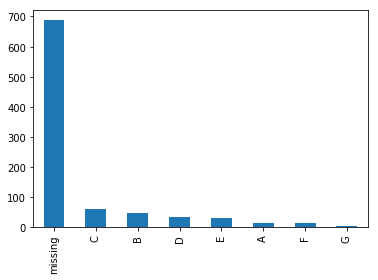

In [54]:
# for 'deck' column missing value must be dominant
X_2_filled['deck'].value_counts().plot.bar();

# Not So Simple Pipeline
* take only numeric columns
* fill missing values by median
* scale with standard scaler
* reduce dimensionality
* train model

In [57]:
steps = [
    ('selector', SelectColumnsByTypeTransformer(type_to_select='numeric')), 
    ('imputer', ImputeNumColsTransformer(method='median')), 
    ('scaler', StandardScaler()),
    ('pca', PCA()), 
    ('model', LogisticRegression())
]

pipeline_2 = Pipeline(steps=steps)
pipeline_2.fit(X_train, y_train)
pipeline_2.predict(X_test)
pipeline_2.score(X_test, y_test)

0.7039106145251397

## Task 6
* create a pipeline:
    * select two columns - age and class
    * impute missing data with mean
    * scale data with MinMaxScaler
    * reduce dimensionality to 2 dimensions
    * train the model

In [ ]:
X_train.head()

In [58]:
steps = [
    ('selector', SelectColumnsTransformer(columns_to_select=['age', 'pclass'])),         
    ('imputer', ImputeNumColsTransformer(method='mean')), 
    ('scaler', MinMaxScaler()),
    ('pca', PCA(2)), 
    ('model', LogisticRegression()) 
]

pipeline_2 = Pipeline(steps=steps)
pipeline_2.fit(X_train, y_train)

pipeline_2.score(X_test, y_test)

0.7039106145251397

In [59]:
pipeline_2.score(X_train, y_train)

0.7050561797752809

### Pipelines apply the same type of transformations to all the columns in the dataset. What if we need to differently handle numeric and categorical columns?

# Feature Union

## Pipeline structure using Feature Union and custom transformers

1. Remove unnecessary or redundant columns
2. Divide all columns into groups with similar handling procedures: __categorical columns__, __numerical columns__

<br>For numerical columns:
    * Impute missing values
    * Scale data
    
<br>For categorical columns:
    * Impute missing values
    * Encode values

3. Train models

## Utility

In [60]:
# result of FeatureUnion is numpy array => turn back to pandas dataframe to enhance readability
def make_df(array, columns):
    return pd.DataFrame(array, columns=columns)

## How to combine pipelines together?

In [61]:
numeric_columns = ['pclass', 'age']
cat_columns = ['sex', 'embarked']

### Numerical pipeline

In [62]:
df_raw.head(2)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,1,2,female,50.0,0,0,10.500,S,Second,woman,False,NaN,Southampton,yes,True
1,0,1,male,36.0,0,0,40.125,C,First,man,True,A,Cherbourg,no,True


In [63]:
num_steps = [('select_num_columns', SelectColumnsTransformer(numeric_columns))]
num_pipeline = Pipeline(steps=num_steps)
num_pipeline.transform(df_raw).head()

,pclass,age
0,2,50.0
1,1,36.0
2,3,NaN
3,3,2.0
4,2,25.0


### Categorical pipeline

In [64]:
cat_steps = [('select_cat_columns', SelectColumnsTransformer(cat_columns))]
cat_pipeline = Pipeline(steps=cat_steps)
cat_pipeline.fit_transform(df_raw).head()

,sex,embarked
0,female,S
1,male,C
2,male,S
3,male,S
4,male,S


### Combine two pipelines into single bigger one

In [65]:
# list of pipelines
# in our case we have two: numeric and categorical. Can be more
transformer_list = [ ('categorical_pipeline', cat_pipeline), 
                     ('numerical_pipeline', num_pipeline ) 
                   ]

# list of pipelines is passed to FeatureUnion
combined_pipeline = FeatureUnion(transformer_list=transformer_list)

# the result will be 4 columns => firstly 2 cat columns, then 2 numeric columns
df_combined = combined_pipeline.fit_transform(df_raw)
df_combined

array([['female', 'S', 2.0, 50.0],
       ['male', 'C', 1.0, 36.0],
       ['male', 'S', 3.0, nan],
       ...,
       ['female', 'S', 2.0, 44.0],
       ['female', 'C', 3.0, nan],
       ['female', 'S', 3.0, 1.0]], dtype=object)

In [66]:
combined_pipeline.fit(X_train)
combined_pipeline.transform(X_test)[:5]

array([['male', 'S', 3.0, nan],
       ['male', 'S', 3.0, 47.0],
       ['male', 'S', 2.0, 0.67],
       ['female', 'S', 3.0, 26.0],
       ['male', 'C', 3.0, nan]], dtype=object)

'combined_pipeline' can be used then as a step in the pipeline with estimator: <br>
1st step - combined_pipeline <br>
2nd step - estomator (e.g., Logistic regression)


In [68]:
# to make it more readable
df_combined = make_df(df_combined, columns=cat_columns + numeric_columns)
df_combined.head()

,sex,embarked,pclass,age
0,female,S,2,50
1,male,C,1,36
2,male,S,3,NaN
3,male,S,3,2
4,male,S,2,25


## Task 7
* the first pipeline for numeric columns: age, pclass
* the second pipeline for categorical columns: sex, embarked
* numeric pipeline does: feature selection, missing values imputation by median, scaling, dimensionality reduction
* categorical pipeline does: feature selection, missing values imputation, one hot encoding
* two subsets are combined together using FeatureUnion
* final dataset is used to train the logistic regression model => new pipeline containing two steps: feature union and logistic regression
* evaluate the model

__NOTE:__ <br>
1) OneHotEncoder(sparse=False, handle_unknown='ignore') <br>
2) Pipeline should be fitted on X_train, y_train and validated on X_test, y_test

In [ ]:
df_raw.head(1)

In [69]:
# list of columns: numeric and categorical
num_columns = ['age', 'pclass']
cat_columns = ['sex', 'embarked']

# steps for numeric and categorical pipelines
num_steps = [
            ('select_num_columns', SelectColumnsTransformer(num_columns)), 
            ('impute', ImputeNumColsTransformer(method='median')), 
            ('scaler', MinMaxScaler()), 
            ('dim_red', PCA(2))
]

cat_steps = [
            ('select_cat_columns', SelectColumnsTransformer(cat_columns)), 
            ('impute', ImputeCatColsTransformer(method='mode')), 
            ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
]

# pipelines themself
num_pipeline = Pipeline(num_steps)
cat_pipeline = Pipeline(cat_steps)

# combining transformed numeric and categorical columns using FeatureUnion
transformer_list = [ ('categorical_pipeline', cat_pipeline), 
                     ('numerical_pipeline', num_pipeline ) 
                   ]

combined_pipeline = FeatureUnion(transformer_list=transformer_list)

# final pipeline containg features united and estimator - Logistic Regression
final_pipeline = Pipeline(steps = [
    ('combined_pipeline', combined_pipeline), 
    ('log_reg', LogisticRegression())
])


# train pipeline on train dataset
final_pipeline.fit(X_train, y_train)

# validate pipeline on test dataset
final_pipeline.score(X_test, y_test)

0.8156424581005587

In [70]:
# using pipeline for prediction
final_pipeline.predict(X_test)

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1])

# Columns Transformer

In [71]:
# numeric pipeline
numeric_columns = ['pclass', 'age', 'sibsp', 'parch', 'fare'] 
numeric_transformer = Pipeline(steps=[
    # SimpleImputer is ready to use class from sklearn
    ('impute_num_columns', SimpleImputer(strategy='mean')), 
    ('scale_data', MinMaxScaler())
])

# categorical pipeline
cat_columns = ['sex', 'embarked', 'who', 'alone']
categorical_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')), 
    ('encoder', OneHotEncoder(sparse=False ,handle_unknown='ignore'))
])

# transformer = numerical + categorical
transformer = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns), 
    ('cat', categorical_transformer, cat_columns)
])

# final pipeline with model
pipeline = Pipeline(steps=[('preprocessor', transformer),
                      ('classifier', LogisticRegression())])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('impute_num_columns', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
   ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [72]:
pipeline.score(X_test, y_test)

0.8324022346368715

In [73]:
preds = pipeline.predict(X_test)

metrics = [accuracy_score, precision_score, recall_score, f1_score]
metrics_name = ['Accuracy', 'Precision', 'Recall', 'F1']

for metric, name in zip(metrics, metrics_name):
    print(f'{name}: {round(metric(preds, y_test),3)}')

Accuracy: 0.832
Precision: 0.768
Recall: 0.791
F1: 0.779


In [ ]:
df_raw.head(1)

## Task 8
* implement transformer for log transformation (if value = 0 => 0 else log of value)


In [79]:
# outliers for "age" column
age = df_raw['fare']
iqr = np.nanpercentile(age, 75) - np.nanpercentile(age, 25)
lower, upper = (np.nanpercentile(age, 25) - 1.5 * iqr), (np.nanpercentile(age, 75) + 1.5 * iqr) 

# what is out of range can be treated as outlier
lower, upper

(-26.724, 65.6344)

In the transformer's method fit, for each column of the dataset X it shoould learn two values: low and high <br>
Next, in the tansform method: 
* if the value is higher than upper, make it equal to upper
* if the value is lower than lower, make it equal to lower

The values can be stored in the transformer's attribite __self.boundaries__ in the form like this: <br>
{ <br>
'column_name_1': [lower_value_1, upper_value_1], <br>
'column_name_2': [lower_value_2, upper_value_2], <br>
...<br>
}


In [74]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__( self):
        pass
        
    def fit(self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        def log_transform(x):
            return 0 if x==0 else np.log(x)
        
        X = pd.DataFrame(X)
        for col in X:
            X[col] = X[col].apply(log_transform)
        return X

In [75]:
X_log = df_raw['fare'] # has zero values
log_transformer = LogTransformer()
log_transformer.fit(X_log)

LogTransformer()

In [76]:
log_transformer.transform(X_log)[:5]

,fare
0,2.351375
1,3.692000
2,2.085672
3,3.048088
4,2.564949


In [77]:
X_log.head()

0    10.500
1    40.125
2     8.050
3    21.075
4    13.000
Name: fare, dtype: float64

## Task 8.1 (optional)
* implement transformer for removing outliers from numeric columns

In [80]:
class RemoveOutliersTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.boundaries = {}
        
    def fit( self, X, y = None ):
        for col in X:
            iqr = np.nanpercentile(X[col], 75) - np.nanpercentile(X[col], 25)
            lower, upper = (np.nanpercentile(X[col], 25) - 1.5 * iqr), (np.nanpercentile(X[col], 75) + 1.5 * iqr)
            self.boundaries[col] = [lower, upper]   
        return self 
    
    def transform( self, X, y = None ):
        for col in X:
            # if values are smaller than lower, make them lower
            X.loc[X[col] < self.boundaries[col][0], col] = self.boundaries[col][0]
            
            # if values are bigger than upper, make them upper
            X.loc[X[col] > self.boundaries[col][1], col] = self.boundaries[col][1]
        return X

In [81]:
X_outliers = df_raw[['age', 'fare']]
X_outliers.describe()

,age,fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200


In [82]:
rot = RemoveOutliersTransformer()
rot.fit(X_outliers)

RemoveOutliersTransformer()

In [83]:
rot.boundaries

{'age': [-6.6875, 64.8125], 'fare': [-26.724, 65.6344]}

In [84]:
X_outliers_transformed = rot.transform(X_outliers)

In [85]:
X_outliers_transformed.describe()

,age,fare
count,714.000000,891.000000
mean,29.622700,24.046813
std,14.316665,20.481625
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,64.812500,65.634400


## Task 9
Using ColumnsTransformer, implement the pipeline:
* first sub_pipeline takes columns: fare, sibsp, parch
* transformations: missing values by median, removing outliers, log transformation, scaling
<br> <br>
* second sub_pipeline takes columns: age, pclass
* transformations: missing values by mean, scaling
<br><br>
* third sub_pipeline takes columns: sex, embarked, alone
* transformations: missing values by mode, OHE
<br><br>
* final pipeline to train using Logistic Regression

In [86]:
# sub_pipeline_1 implemented
cols_1 = ['fare', 'sibsp', 'parch']
transformer_1 = Pipeline(steps=[
    ('impute_num_columns', ImputeNumColsTransformer(method='median')), 
    ('remove_outliers', RemoveOutliersTransformer()), 
    ('log_transform', LogTransformer()),
    ('scale_data', MinMaxScaler())
])

# sub_pipeline_2 implemented
cols_2 = ['age', 'pclass']
transformer_2 = Pipeline(steps = [
    ('impute_num_columns', ImputeNumColsTransformer(method='mean')), 
    ('scale_data', MinMaxScaler())
])

# sub_pipeline_3 implemented
cols_3 = ['sex', 'embarked', 'alone']
transformer_3 = Pipeline(steps = [
    ('impute_cat_columns', ImputeCatColsTransformer(method='mode')), 
    ('ohe', OneHotEncoder(sparse=False ,handle_unknown='ignore'))
])


# transformer = numerical + categorical
transformer = ColumnTransformer(transformers=[
    ('num_1', transformer_1, cols_1), 
    ('num_2', transformer_2, cols_2), 
    ('cat_1', transformer_3, cols_3),
])

# final pipeline with model
pipeline = Pipeline(steps=[('preprocessor', transformer),
                      ('classifier', LogisticRegression())])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num_1', Pipeline(memory=None,
     steps=[('impute_num_columns', ImputeNumColsTransformer(method='median')), ('remove_outliers', RemoveOutliersTr...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [87]:
pipeline.score(X_test, y_test)

0.8044692737430168

In [ ]:
df_raw.head(2)

## Task 10
* modify the pipeline form the Task 9
* create __WhoTransformer__ to create new binary feature based on columns 'who': whether the person is child or not
* the new pipeline will have 4 sub_pipelines

In [88]:
df_raw['who'].unique()

array(['woman', 'man', 'child'], dtype=object)

In [89]:
class WhoTransformer(BaseEstimator, TransformerMixin):
    def __init__( self):
        pass
        
    def fit(self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        X = pd.DataFrame(X)
        for col in X:
            X[col] = X[col].apply(lambda x: 1 if x == 'child' else 0)
        return X

In [90]:
WhoTransformer().fit_transform(df_raw['who']).head()

,who
0,0
1,0
2,0
3,1
4,0


In [ ]:
df_raw['who'].head()

In [91]:
# sub_pipeline_1 implemented
cols_1 = ['fare', 'sibsp', 'parch']
transformer_1 = Pipeline(steps=[
    ('impute_num_columns', ImputeNumColsTransformer(method='median')), 
    ('remove_outliers', RemoveOutliersTransformer()), 
    ('log_transform', LogTransformer()),
    ('scale_data', MinMaxScaler())
])

# sub_pipeline_2 implemented
cols_2 = ['age', 'pclass']
transformer_2 = Pipeline(steps = [
    ('impute_num_columns', ImputeNumColsTransformer(method='mean')), 
    # log transf
    ('scale_data', MinMaxScaler())
])

# sub_pipeline_3 implemented
cols_3 = ['sex', 'embarked', 'alone']
transformer_3 = Pipeline(steps = [
    ('impute_cat_columns', ImputeCatColsTransformer(method='mode')), 
    ('ohe', OneHotEncoder(sparse=False ,handle_unknown='ignore'))
])

cols_4 = ['who']
transformer_4 = Pipeline(steps = [
    ('impute_cat_columns', ImputeCatColsTransformer(method='mode')), 
    ('who_transformer', WhoTransformer())
])


# transformer = numerical + categorical
transformer = ColumnTransformer(transformers=[
    ('num_1', transformer_1, cols_1), 
    ('num_2', transformer_2, cols_2), 
    ('cat_1', transformer_3, cols_3),
    ('cat_2', transformer_4, cols_4)
])

# final pipeline with model
my_pipeline = Pipeline(steps=[('preprocessor', transformer),
                      ('classifier', LogisticRegression())])

my_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num_1', Pipeline(memory=None,
     steps=[('impute_num_columns', ImputeNumColsTransformer(method='median')), ('remove_outliers', RemoveOutliersTr...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [92]:
my_pipeline.score(X_test, y_test)

0.8212290502793296

### Number of columns in transformed dataset:
1. ['fare', 'sibsp', 'parch'] => 3
2. ['age', 'pclass'] => 2
3. ['sex', 'embarked', 'alone'] => 2 for sex, 3 for embarked, 2 for alone => 7
4. ['who'] => 1
<br> 
__Total__: 3 + 2 + 7 + 1 = 13
<br><br>

Improvements for the pipeline:
* OHE apply only to 'embarked'
* for 'sex', 'alone' and 'who' implement BinaryEncodeTransformer which takes list of columns to encode and list of categories top be considered as 1; all others will be zeros 


In [93]:
my_pipeline.named_steps['preprocessor'].named_transformers_

{'num_1': Pipeline(memory=None,
      steps=[('impute_num_columns', ImputeNumColsTransformer(method='median')), ('remove_outliers', RemoveOutliersTransformer()), ('log_transform', LogTransformer()), ('scale_data', MinMaxScaler(copy=True, feature_range=(0, 1)))]),
 'num_2': Pipeline(memory=None,
      steps=[('impute_num_columns', ImputeNumColsTransformer(method='mean')), ('scale_data', MinMaxScaler(copy=True, feature_range=(0, 1)))]),
 'cat_1': Pipeline(memory=None,
      steps=[('impute_cat_columns', ImputeCatColsTransformer(method='mode')), ('ohe', OneHotEncoder(categorical_features=None, categories=None,
        dtype=<class 'numpy.float64'>, handle_unknown='ignore',
        n_values=None, sparse=False))]),
 'cat_2': Pipeline(memory=None,
      steps=[('impute_cat_columns', ImputeCatColsTransformer(method='mode')), ('who_transformer', WhoTransformer())]),
 'remainder': 'drop'}

In [94]:
# 1. pipeline object
# 2. transformer
# 3. one of the transfomers => Pipeline
# 4. step of the Pipeline
my_pipeline.named_steps['preprocessor'].named_transformers_['num_1'].named_steps['impute_num_columns']

ImputeNumColsTransformer(method='median')

In [95]:
my_pipeline = Pipeline(steps=[
                        ('preprocessor', transformer),
                        ('classifier', LogisticRegression())
])

my_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num_1', Pipeline(memory=None,
     steps=[('impute_num_columns', ImputeNumColsTransformer(method='median')), ('remove_outliers', RemoveOutliersTr...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [96]:
my_pipeline.score(X_test, y_test)

0.8212290502793296

# Grid Search for Pipelines

In [97]:
# what we can tune?
list(my_pipeline.get_params().keys())

['memory',
 'steps',
 'preprocessor',
 'classifier',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__num_1',
 'preprocessor__num_2',
 'preprocessor__cat_1',
 'preprocessor__cat_2',
 'preprocessor__num_1__memory',
 'preprocessor__num_1__steps',
 'preprocessor__num_1__impute_num_columns',
 'preprocessor__num_1__remove_outliers',
 'preprocessor__num_1__log_transform',
 'preprocessor__num_1__scale_data',
 'preprocessor__num_1__impute_num_columns__method',
 'preprocessor__num_1__scale_data__copy',
 'preprocessor__num_1__scale_data__feature_range',
 'preprocessor__num_2__memory',
 'preprocessor__num_2__steps',
 'preprocessor__num_2__impute_num_columns',
 'preprocessor__num_2__scale_data',
 'preprocessor__num_2__impute_num_columns__method',
 'preprocessor__num_2__scale_data__copy',
 'preprocessor__num_2__scale_data__feature_range',
 'preprocessor__cat_1__memory',
 'prep

In [98]:
my_pipeline.named_steps['preprocessor'].named_transformers_['num_1']

Pipeline(memory=None,
     steps=[('impute_num_columns', ImputeNumColsTransformer(method='median')), ('remove_outliers', RemoveOutliersTransformer()), ('log_transform', LogTransformer()), ('scale_data', MinMaxScaler(copy=True, feature_range=(0, 1)))])

In [99]:
param_grid = {
    'preprocessor__num_1__impute_num_columns__method': ['mean', 'median'],
    'classifier__C': [0.1, 1.0]
}

In [100]:
grid_search = GridSearchCV(my_pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num_1', Pipeline(memory=None,
     steps=[('impute_num_columns', ImputeNumColsTransformer(method='median')), ('remove_outliers', RemoveOutliersTr...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'preprocessor__num_1__impute_num_columns__method': ['mean', 'median'], 'classifier__C': [0.1, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [101]:
print(("best logistic regression from grid search: %.3f" % grid_search.score(X_test, y_test)))
print(grid_search.best_params_)

best logistic regression from grid search: 0.821
{'classifier__C': 0.1, 'preprocessor__num_1__impute_num_columns__method': 'mean'}


In [102]:
from sklearn.svm import SVC

param_grid = dict(preprocessor__num_1__impute_num_columns__method=['median', 'mean'], 
                  preprocessor__num_1__scale_data=[None, MinMaxScaler(), StandardScaler()],
                  preprocessor__num_1__log_transform=[None, LogTransformer()],
                  classifier=[LogisticRegression(), SVC()], 
                  classifier__C=[0.1, 1, 10]
                 )

grid_search = GridSearchCV(my_pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num_1', Pipeline(memory=None,
     steps=[('impute_num_columns', ImputeNumColsTransformer(method='median')), ('remove_outliers', RemoveOutliersTr...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'preprocessor__num_1__impute_num_columns__method': ['median', 'mean'], 'preprocessor__num_1__scale_data': [None, MinMaxScaler(copy=True, feature_range=(0, 1)), StandardScaler(copy=True, with_mean=True, with_std=True)], 'preprocessor__num_1__log_transform': [None, LogTransformer()], 'clas...lse, random_state=None,
  shrinking=True, tol=0.001, verbose=False)], 'classifier__C': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit

In [103]:
import pprint

In [104]:
print(("best logistic regression from grid search: %.3f" % grid_search.score(X_test, y_test)))
pprint.pprint(grid_search.best_params_)

best logistic regression from grid search: 0.872
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
 'classifier__C': 10,
 'preprocessor__num_1__impute_num_columns__method': 'median',
 'preprocessor__num_1__log_transform': None,
 'preprocessor__num_1__scale_data': MinMaxScaler(copy=True, feature_range=(0, 1))}


## Task 11: 
* implement grid search for the pipeline
* focus on 'num_2' step of the pipeline